In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, Grayscale, ToPILImage
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import PIL

from imagenet_c import corrupt
from CLIP import clip
from utils import load_dataloaders_ImageNet

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)

# path_data = '/scratchf/'
path_data = os.path.expandvars('$DSDIR')
device = "cuda" if torch.cuda.is_available() else "cpu"

/tmp/ipykernel_1953601/2530483084.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
BATCH_SIZE = 64

In [3]:
# LOAD DATA

# path_dataset = path_data + 'IMAGENET'
# dataloader_train, dataloader_val = load_dataloaders_ImageNet(path_dataset, BATCH_SIZE)

# # LOAD MODEL
# weights = ResNet50_Weights.IMAGENET1K_V2
# classifier = resnet50(weights=weights).to(device)
# # preprocess = weights.transforms()
# classifier.eval()


test_data = datasets.MNIST(
                root=path_data,
                train=False,
                download=False,
                # transform=ToPILImage()
                # transform=Compose([
                #     # Resize(244),
                #     # Grayscale(3), # to RGB
                #     # corruption_transform,
                #     ToTensor(),
                #     # Resize(28),
                #     # Grayscale(),
                # ])
            )
model, preprocess = clip.load("ViT-B/32", device=device)

# CLIP zero-shot classif

In [ ]:
image, class_id = test_data[0]
image

In [ ]:
# Prepare the inputs
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in range(10)]).to(device)

In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

In [ ]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
print(f'Classified as {indices[0]} (proba {values[0]*100:.0f}%)')

# CLIP corruption prediction

In [ ]:
image, class_id = test_data[1]

image_corr = corrupt(np.array(image), severity=3, corruption_name='gaussian_blur')
image_corr = PIL.Image.fromarray(np.uint8(image_corr))
image_corr

In [ ]:
# Prepare the inputs
image_input = torch.cat((preprocess(image).unsqueeze(0), preprocess(image_corr).unsqueeze(0)), dim=0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a blurred photo")]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
    
# Similarity between images and text
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T)
similarity = similarity / similarity.max()
print(f'Similarities to prompt: {similarity}')

### On full dataset

Extract valid corruptions

In [15]:
# from imagenet_c.corruptions import (
#     gaussian_noise, shot_noise, impulse_noise, defocus_blur,
#     glass_blur, motion_blur, zoom_blur, snow, frost, fog,
#     brightness, contrast, elastic_transform, pixelate, jpeg_compression,
#     speckle_noise, gaussian_blur, spatter, saturate)
    
# corruption_tuple = (gaussian_noise, shot_noise, impulse_noise, defocus_blur,
#                     glass_blur, motion_blur, 
#                     zoom_blur, snow, frost, fog,
#                     brightness, contrast, elastic_transform, pixelate, jpeg_compression,
#                     speckle_noise, gaussian_blur, spatter, saturate)

# corruption_dict = {corr_func.__name__: corr_func for corr_func in corruption_tuple}
# corruption_dict.keys()

# valid_corruptions = []
# for c in corruption_dict.keys():
#     try:
#         corrupt(img[i].numpy(), severity=severity, corruption_name=c)
#         valid_corruptions.append(c)
#     except:
#         pass
valid_corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'contrast', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur']
corruption_prompts = {
    'gaussian_noise': 'a noisy image', 
    'shot_noise': 'a noisy image', 
    'impulse_noise': 'a noisy image', 
    'contrast': 'an image with low constrast', 
    'pixelate': 'a very pixelated image', 
    'jpeg_compression': 'an image after jpeg compression', 
    'speckle_noise': 'a noisy image', 
    'gaussian_blur': 'a blurred image'}

gaussian_noise
shot_noise
impulse_noise
contrast
pixelate
jpeg_compression
speckle_noise
gaussian_blur


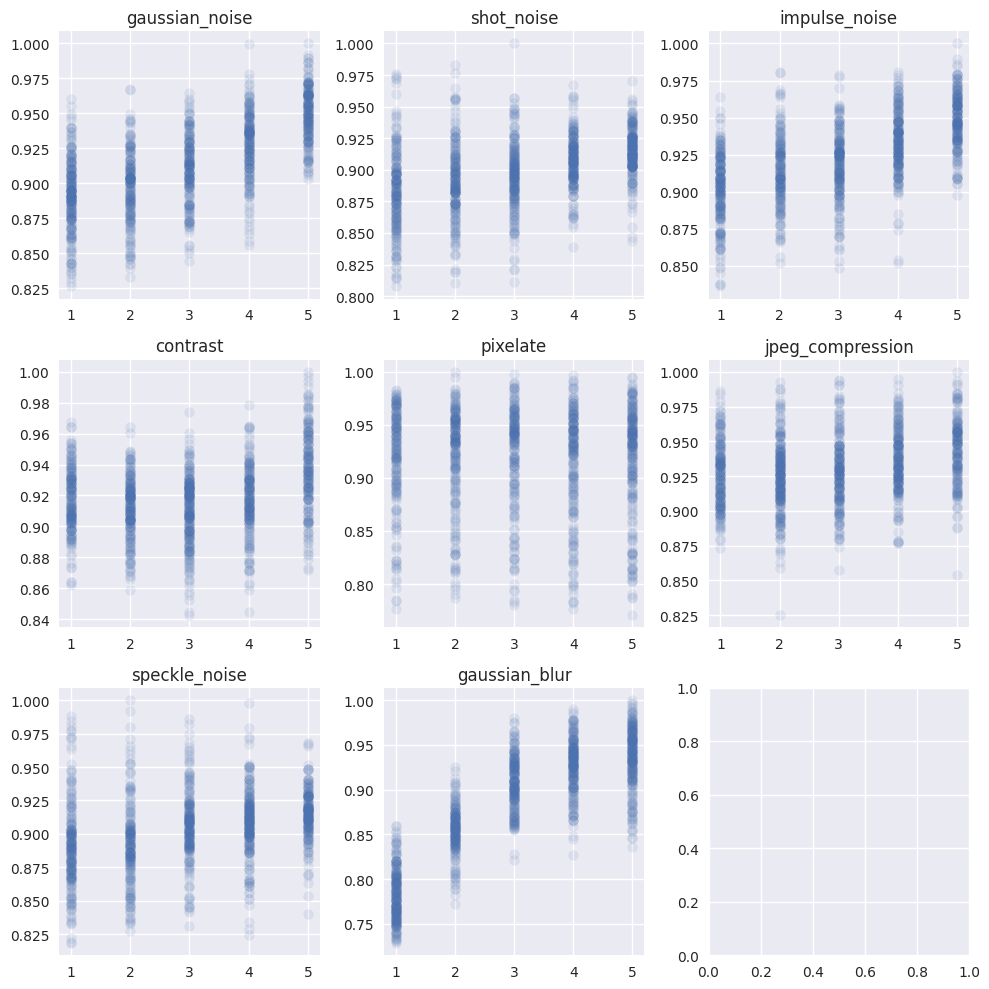

In [17]:
n_samples = 1000

data = datasets.MNIST(
                root=path_data,
                train=False,
                download=False,
                transform=Lambda(lambda x: np.array(x)))
dataloader = DataLoader(data, batch_size=BATCH_SIZE)

fig, axs = plt.subplots(3, 3, figsize=(10,10))
for corruption, ax in zip(corruption_prompts.keys(), fig.axes):
    print(corruption)
    # Generate data (image_input) and labels (corruption_severity)
    idx = 0
    image_input = torch.empty(n_samples, 3, 224, 224)
    corruption_severity = torch.empty(n_samples)
    for batch in dataloader:
        img, _ = batch
        for i in range(img.shape[0]):
            severity = np.random.randint(1, 6)
            img_ = corrupt(img[i].numpy(), severity=severity, corruption_name=corruption)
            image_input[idx] = preprocess(PIL.Image.fromarray(img_))
            corruption_severity[idx] = severity
            idx += 1
            if idx == n_samples: break
        if idx == n_samples: break

    # Prepare the inputs
    image_input = image_input.to(device)
    text_inputs = clip.tokenize(corruption_prompts[corruption]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        
    # Similarity between images and text
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)
    similarity = similarity / similarity.max()

    ax.scatter(corruption_severity, similarity.cpu(), alpha=0.1)
    ax.set_title(corruption)
    # ax.
fig.tight_layout()

### Test different prompts

gaussian_noise
gaussian_noise
gaussian_noise
gaussian_noise
gaussian_noise
gaussian_noise
gaussian_noise
gaussian_noise


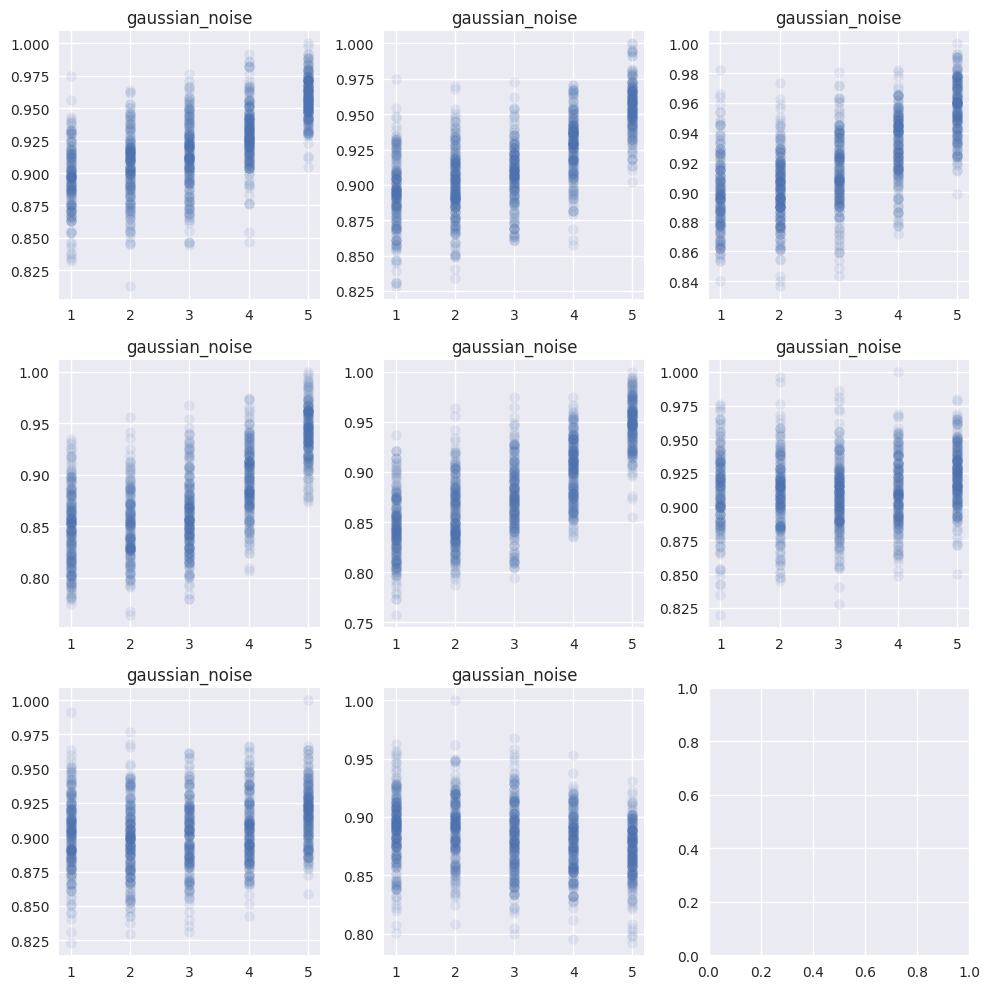

In [21]:
prompts = ['a noisy image', 'a very noisy image', 'an extremely noisy image', 
           'an image corrupted by noise', 'an image very corrupted by noise', 'a noisy picture of a digit', 
           'a very noisy image of a digit', 'a very noisy image of a handwritten digit']
corruption = 'gaussian_noise'


n_samples = 1000

data = datasets.MNIST(
                root=path_data,
                train=False,
                download=False,
                transform=Lambda(lambda x: np.array(x)))
dataloader = DataLoader(data, batch_size=BATCH_SIZE)

fig, axs = plt.subplots(3, 3, figsize=(10,10))
for prompt, ax in zip(prompts, fig.axes):
    print(corruption)
    # Generate data (image_input) and labels (corruption_severity)
    idx = 0
    image_input = torch.empty(n_samples, 3, 224, 224)
    corruption_severity = torch.empty(n_samples)
    for batch in dataloader:
        img, _ = batch
        for i in range(img.shape[0]):
            severity = np.random.randint(1, 6)
            img_ = corrupt(img[i].numpy(), severity=severity, corruption_name=corruption)
            image_input[idx] = preprocess(PIL.Image.fromarray(img_))
            corruption_severity[idx] = severity
            idx += 1
            if idx == n_samples: break
        if idx == n_samples: break

    # Prepare the inputs
    image_input = image_input.to(device)
    text_inputs = clip.tokenize(prompt).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        
    # Similarity between images and text
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)
    similarity = similarity / similarity.max()

    ax.scatter(corruption_severity, similarity.cpu(), alpha=0.1)
    ax.set_title(corruption)
    # ax.
fig.tight_layout()